<a href="https://colab.research.google.com/github/AnnieCRY/DS5230-project/blob/master/beehive_audio_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get processed data

In [65]:
# mount google drive
from google.colab import drive
drive.mount("/content/gdrive")


! cp -r gdrive/My\ Drive/5230Project/processed_data_25 ./

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# download the supporting files from github
! rm -rf Audio_based_identification_beehive_states/
! git clone https://github.com/Tonyz4516/Audio_based_identification_beehive_states.git

! mv Audio_based_identification_beehive_states/Bee_NotBee_classification/* ./

Cloning into 'Audio_based_identification_beehive_states'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 118 (delta 0), reused 0 (delta 0), pack-reused 114
Receiving objects: 100% (118/118), 69.02 KiB | 5.75 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
! pip install muda

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import numpy, scipy, matplotlib.pyplot as plt, sklearn, librosa, mir_eval, IPython.display, urllib


### State
X_state, Y_state

In [75]:
block_size = 5
path_workingFolder = '/content/processed_data_25'+os.sep  # path where to save audio segments and labels files.
labels2read = 'labels_BeeNotBee_th0'
feature = 'MFCCs20'
#sample_ids_test, sample_ids_train, sample_ids_val = get_samples_id_perSet(path_workingFolder+'split_random_0.json') 

In [76]:
def get_state_labels():
  csv_file = path_workingFolder+"state_labels.csv"
  df = pd.read_csv(csv_file)
  return df['label'],df['sample_name']


In [77]:
state_label, state_ids = get_state_labels()
state_ids_name = []
for id in state_ids:
  state_ids_name.append(id+'.wav')

In [78]:
set(state_label)
Y_state=state_label

In [97]:
set(Y_state)

{'active', 'missing queen'}

In [79]:
X_state = get_features_from_samples(path_workingFolder, state_ids_name, 'MFCCs20', 'NO', 1)

### BeeNotBee
X,Y

In [81]:
def modify_labels():
    csv_file = path_workingFolder+"labels_BeeNotBee_th0.csv"
    labels_BeeNotBee_th0 = pd.read_csv(csv_file)

    def add_new_labels(df):
        labels_l=[]
        for x in df['label_strength']:
            if x>0.95:
                labels_l.append('nobee') 
            elif x==0:
                labels_l.append('bee') 
            else:
                labels_l.append('unknown') 
        df['label']=labels_l
        return df,labels_l,df['sample_name']
    
    labels_BeeNotBee_th0,labels,ids=add_new_labels(labels_BeeNotBee_th0)
    labels_BeeNotBee_th0.to_csv(csv_file)
    return labels,ids
labels,ids=modify_labels()

In [82]:
sample_ids=[]
for id in ids:
  sample_ids.append(id+'.wav')

In [83]:
X = get_features_from_samples(path_workingFolder, sample_ids, 'MFCCs20', 'NO', 1)
# X_val = get_features_from_samples(path_workingFolder, sample_ids_val, 'MFCCs20', 'NO', 1)
# X_test = get_features_from_samples(path_workingFolder, sample_ids_test, 'MFCCs20', 'NO', 1)
    

In [84]:
Y=labels

In [15]:
# add normalizat - min_max
#X_train_norm = get_features_from_samples(path_workingFolder, sample_ids_train, 'MFCCs20', 'min_max', 1)

In [9]:
# labels_train = get_GT_labels_fromFiles(path_workingFolder, sample_ids_train, labels2read)
# Y_train= labels2binary('nobee', labels_train)
    
# labels_val = get_GT_labels_fromFiles(path_workingFolder, sample_ids_val, labels2read)
# Y_val= labels2binary('nobee', labels_val)
    
# labels_test = get_GT_labels_fromFiles(path_workingFolder, sample_ids_test, labels2read)
# Y_test= labels2binary('nobee', labels_test)

## pca

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
Y

In [85]:
pca2 = PCA(n_components = 2).fit_transform(X)

pca2_df = pd.DataFrame(data = pca2, columns = ['component1', 'component2'])

pca2_df = pd.concat([pca2_df, pd.DataFrame(Y, columns = ['label'])], axis = 1)

In [86]:
pca2_state = PCA(n_components = 2).fit_transform(X_state)

pca2_df_state = pd.DataFrame(data = pca2_state, columns = ['component1', 'component2'])

pca2_df_state = pd.concat([pca2_df_state, pd.DataFrame(Y_state, columns = ['label'])], axis = 1)

Text(0.5, 1.0, 'True label-bee/noBee')

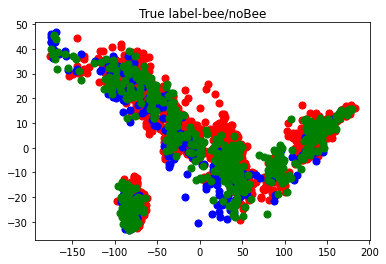

In [96]:
plt.scatter(pca2_df[pca2_df['label']=='bee'].iloc[:,0], pca2_df[pca2_df['label']=='bee'].iloc[:,1], c='r', s=50, cmap='viridis')
plt.scatter(pca2_df[pca2_df['label']=='nobee'].iloc[:,0], pca2_df[pca2_df['label']=='nobee'].iloc[:,1], c='b', s=50, cmap='viridis')
plt.scatter(pca2_df[pca2_df['label']=='unknown'].iloc[:,0], pca2_df[pca2_df['label']=='unknown'].iloc[:,1], c='g', s=50, cmap='viridis')

plt.title("True label-bee/noBee")

Text(0.5, 1.0, 'True label-missing queen/active')

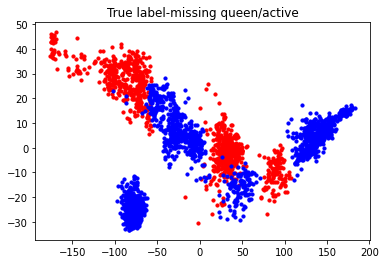

In [101]:
plt.scatter(pca2_df_state[pca2_df_state['label']=='missing queen'].iloc[:,0], pca2_df_state[pca2_df_state['label']=='missing queen'].iloc[:,1], c='r', s=10, cmap='viridis')
plt.scatter(pca2_df_state[pca2_df_state['label']=='active'].iloc[:,0], pca2_df_state[pca2_df_state['label']=='active'].iloc[:,1], c='b', s=10, cmap='viridis')
plt.title("True label-missing queen/active")

tsne

In [102]:
tsne = TSNE(n_components=2).fit_transform(X_state)

tsne_df = pd.DataFrame(data = tsne, columns = ['component1', 'component2'])

tsne_df = pd.concat([tsne_df, pd.DataFrame(Y_state, columns = ['label'])], axis = 1)

Text(0.5, 1.0, 'True label-missing queen/active')

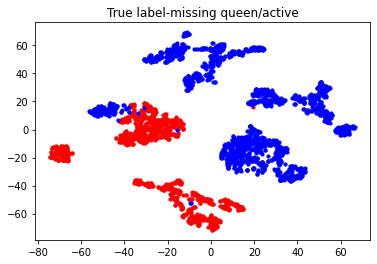

In [103]:
plt.scatter(tsne_df[tsne_df['label']=='missing queen'].iloc[:,0], tsne_df[tsne_df['label']=='missing queen'].iloc[:,1], c='r', s=10, cmap='viridis')
plt.scatter(tsne_df[tsne_df['label']=='active'].iloc[:,0], tsne_df[tsne_df['label']=='active'].iloc[:,1], c='b', s=10, cmap='viridis')
plt.title("True label-missing queen/active")

In [100]:
plt.scatter(pca_df[pca_df['label']=='bee'].iloc[:,0], pca_df[pca_df['label']=='bee'].iloc[:,1], c='r', s=50, cmap='viridis')
plt.scatter(pca_df[pca_df['label']=='nobee'].iloc[:,0], pca_df[pca_df['label']=='nobee'].iloc[:,1], c='b', s=50, cmap='viridis')
plt.legend(c)
plt.title("True label")

KeyError: ignored

In [88]:
pca3 = PCA(n_components = 3).fit_transform(X)
pca3_df = pd.DataFrame(data = pca3, columns = ['PC1', 'PC2','PC3'])
pca3_df = pd.concat([pca3_df, pd.DataFrame(Y, columns = ['label'])], axis = 1)

pca3_state = PCA(n_components = 3).fit_transform(X_state)
pca3_df_state = pd.DataFrame(data = pca3_state, columns = ['PC1', 'PC2','PC3'])
pca3_df_state = pd.concat([pca3_df_state, pd.DataFrame(Y_state, columns = ['label'])], axis = 1)

In [89]:
fig = px.scatter_3d(pca3_df, x='PC1', y='PC2', z='PC3',color='label')
fig.show()

In [90]:
import plotly.express as px
fig = px.scatter_3d(pca3_df_state, x='PC1', y='PC2', z='PC3',color='label')
fig.show()

## K-means

In [66]:
from sklearn.preprocessing import normalize

In [105]:
model = sklearn.cluster.KMeans(n_clusters=2)
Y_tsne = model.fit_predict(tsne)

In [109]:
model = sklearn.cluster.KMeans(n_clusters=2)
Y_pred = model.fit_predict(X)
Y_pred

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [23]:
labels_norm = model.fit_predict(X_train_norm)
labels_norm

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [57]:
pred_km_state = pd.concat([pca3_df_state, pd.DataFrame(list(Y_pred), columns = ['predicted_label'])],axis=1)

In [106]:
pred_km = pd.concat([pca_df, pd.DataFrame(list(Y_tsne), columns = ['predicted_label'])],axis=1)

plot results 

In [69]:
fig = px.scatter_3d(pca3_df, x='PC1', y='PC2', z='PC3',color='label')
fig.show()

In [70]:
fig = px.scatter_3d(pred_km, x='PC1', y='PC2', z='PC3',color='predicted_label')
fig.show()

Text(0.5, 1.0, 'prediction with K-means')

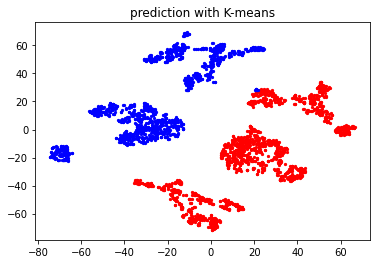

In [108]:

plt.scatter(pred_km[pred_km['predicted_label']==0].iloc[:,0], pred_km[pred_km['predicted_label']==0].iloc[:,1], c='r', s=5, cmap='viridis')
plt.scatter(pred_km[pred_km['predicted_label']==1].iloc[:,0], pred_km[pred_km['predicted_label']==1].iloc[:,1], c='b', s=5, cmap='viridis')

plt.title("prediction with K-means")

Text(0.5, 1.0, 'True label')

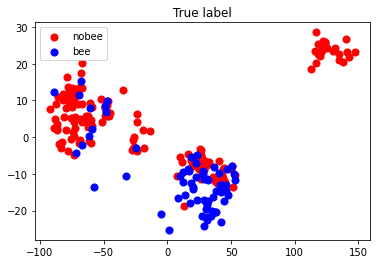

In [ ]:
plt.scatter(pred_km[pred_km['label']==0].iloc[:,0], pred_km[pred_km['label']==0].iloc[:,1], c='r', s=50, cmap='viridis')
plt.scatter(pred_km[pred_km['label']==1].iloc[:,0], pred_km[pred_km['label']==1].iloc[:,1], c='b', s=50, cmap='viridis')

plt.legend(('nobee', 'bee'))
plt.title("True label")

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(list(labels), Y_train)
cm

NameError: ignored

In [39]:
from sklearn.metrics import f1_score
f1_score(labels, Y_train)

0.5096153846153847

In [40]:
from sklearn.metrics import average_precision_score
average_precision_score(labels, Y_train)

0.6624883000904369

In [37]:
accuracy_score(labels, state_label)

TypeError: ignored

In [33]:
accuracy_score(labels_pca, Y_train)

0.5975103734439834

In [38]:
for i in range(1,80):
  print(i)
  pca_80 = PCA(n_components = i).fit_transform(X_train)
  labels_80 = model.fit_predict(pca_80)
  print(accuracy_score(labels_80, Y_train))

[2020-08-10 21:00:55 RAM6.7% 0.23GB] 1
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.4024896265560166
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 2
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.4024896265560166
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 3
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.5975103734439834
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 4
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.4024896265560166
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 5
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.5975103734439834
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 6
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.4024896265560166
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 7
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.5975103734439834
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 8
[2020-08-10 21:00:56 RAM6.7% 0.23GB] 0.5975103734439834
[2020-08-10 21:00:56 RAM6.7% 0.23GB] 9
[2020-08-10 21:00:56 RAM6.7% 0.23GB] 0.4024896265560166
[2020-08-10 21:00:56 RAM6.7% 0.23GB] 10
[2020-08-10 21:00:56 RAM6.7% 0.23GB] 0.5975103734439834
[2020-08-10 21:00:56 RAM6.7% 0.23GB] 11
[2020-08-

In [31]:
#testing dataset
y_test = model.fit_predict(X_test)
accuracy_score(y_test, Y_test)

0.5925925925925926